In [1]:
# Import libraries
import json
import os
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
from matplotlib.pyplot import imshow, imsave
from skimage import io

import sys
sys.path.append("../../ironn/modules/preprocessing")
from convexhull import MyJarvisWalk
from flat_coords import get_flat_coords

## Getting the blasted faces of the mines

In order to get started with IRONN, our first approach is to train a model that can take in an image and then, predict  which parts of a picture belongs to a "Blasted Face" or to the "Background".

We have 448 labeled images. By labeled images, we mean an jpg image that has a corresponding json file. In the json file, we can find annotations of the coordinates of the polygons that segment a rocks of intrest within the blasted face of the mine.

We are defining as "Blasted Face", the part of a mine that has identified polygons.

Since an image can have more than one polygon, we need to take the coordinates of these polygons and make a larger polygon that contains the smaller ones. For this, we are going to use an algorithm called Gift Wrapping or Jarvis March.
 
The intensions of Jarvis March is to only select the minimum number of coordinates that form a convex polygon that includes all the initial set of coordinates.

In [2]:
path = '/Users/seiryu8808/Documents/Capstone/ubc_geodetection1/data/tagfiles/'
files = os.listdir(path)

In [3]:
# Since our json files include a list of lists of tuples (a list of polygons with coordinates), we need
# to just make a flat list. 
# The function flat_coords does this.
# We then apply the functions in the MyJarvisWalk module.

ch = MyJarvisWalk()

# Create Convex-Hull dictionary
convex_hull_dict = {'file name':[], 'hull_coordinates':[]}

# Get file and its Convex Hull coordinates in a data frame
for i in files:
    file = os.path.join(path, i) # Join path + each file
    flat_coords = get_flat_coords(file) 
    convex_hull_coords = ch.convex_hull(flat_coords) # Convex Hull Coordinates
    convex_hull_dict['file name'].append(i)
    convex_hull_dict['hull_coordinates'].append(convex_hull_coords)

complete_convex_hull = pd.DataFrame(convex_hull_dict)

In [4]:
# Show head of result
complete_convex_hull.head()

,file name,hull_coordinates
0,20190601_bp-676-051_MP.json,"[(0, 766), (870, 762), (2218, 768), (2272, 774..."
1,20190430_bw-718-095-10_AS.json,"[(6, 280), (94, 261), (1619, 316), (1618, 931)..."
2,190325_o_BW-718-092_35.json,"[(104, 1340), (106, 1282), (877, 1124), (1514,..."
3,190402_o_BP-676-049_11.json,"[(26, 1975), (54, 1275), (733, 1132), (4583, 1..."
4,20190521-bp-662-009_2_JH.json,"[(26, 2685), (42, 317), (3954, 335), (3913, 26..."


In [5]:
pwd()

'/Users/seiryu8808/Documents/Capstone/ubc_geodetection_review/docs/03_eda_reports'

In [6]:
# Save polygons in a .csv file
complete_convex_hull.to_csv('../../ironn/modules/output/complete_convex_hull_pol.csv')

## Example for one image

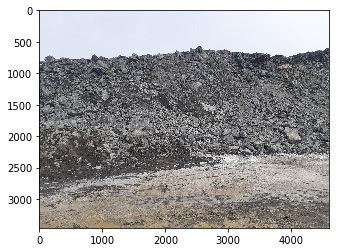

In [8]:
# Loading the image
image = Image.open("../../data/images/test_image.jpg")
imshow(image)

In [9]:
# Now we get the flat coordinates of the image above using its .json file
flat_coords = get_flat_coords('../../data/tagfiles/test_tagfile.json')

In [10]:
# Then, we need to reduce the number to the minimum of coordinates with our Convex Hull

# Initialize the module
my_ch = MyJarvisWalk()

# Apply the model to flat_coords

convex_hull_coords = my_ch.convex_hull(flat_coords)

In [11]:
# Print complete coords and Convex Hull coords just for comparison
print("All coordinates", flat_coords) 
print("\n \n Convex Hull prints just the minimum coordinates that wraps all the coordinates, ", convex_hull_coords)

All coordinates [(72, 810), (1362, 750), (2562, 635), (3626, 703), (3983, 753), (4562, 646), (4572, 2185), (2330, 2143), (69, 2471), (72, 810)]

 
 Convex Hull prints just the minimum coordinates that wraps all the coordinates,  [(69, 2471), (72, 810), (2562, 635), (4562, 646), (4572, 2185), (69, 2471)]


Let's now see how the Convex Hull looks in the image!

In [12]:
draw = ImageDraw.Draw(image)

draw.line(convex_hull_coords, fill = "blue", width=7)


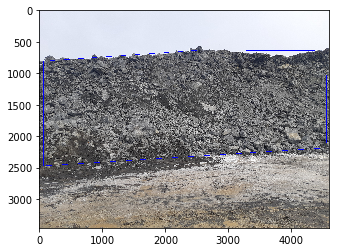

In [13]:
imshow(image)

But wait! what is this encompasing?  How did the original polygons look like before?

In [15]:
# Getting the coordinates from json files
coords = []
avg = None
with open('../../data/tagfiles/test_tagfile.json') as coord:  
    data = json.load(coord)
    curr = []
    for i in range(1):
        curr = []
        for point in data['shapes'][i]['points']:
            curr.append(tuple(point))
        curr.append(curr[0])
        coords.append(curr)

In [16]:
for i in range(len(coords)):
    draw.line(coords[i], fill = "yellow", width=3)

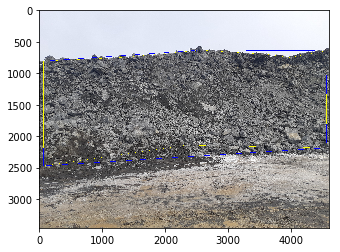

In [17]:
imshow(image)

In [62]:
# io.imsave('./pol_test.JPG', image) # Safe images somewhere

In the above image, we can see that our Convex Hull keeps all the original polygons inside the selected area! Isn't this cool?